In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

<AxesSubplot:ylabel='None'>

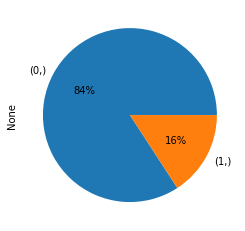

In [6]:
y_train.value_counts().plot(kind='pie', autopct='%1.0f%%')

In [7]:
train = pd.read_pickle('train_886features.pkl') ### 293 features
test = pd.read_pickle('test_886features.pkl')

In [8]:
train.dtypes.value_counts()

float64    793
int32       69
int64       24
dtype: int64

<AxesSubplot:>

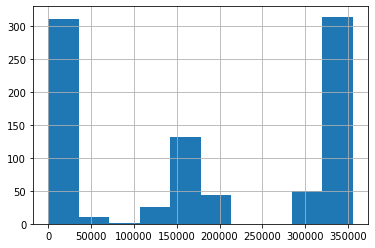

In [9]:
train.isna().sum().hist()

## Entrenando LGBM con hiperparámetros

In [10]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, colsample_bytree=0.8,
                   subsample=0.8, max_bin=200, learning_rate=0.1)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.858563	training's binary_logloss: 0.291167	valid_1's auc: 0.845098	valid_1's binary_logloss: 0.301731
[200]	training's auc: 0.873269	training's binary_logloss: 0.279527	valid_1's auc: 0.849593	valid_1's binary_logloss: 0.297966
[300]	training's auc: 0.883379	training's binary_logloss: 0.271322	valid_1's auc: 0.85079	valid_1's binary_logloss: 0.29691
Early stopping, best iteration is:
[311]	training's auc: 0.884357	training's binary_logloss: 0.270534	valid_1's auc: 0.850842	valid_1's binary_logloss: 0.296852
********** 1 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.858886	training's binary_logloss: 0.291032	valid_1's auc: 0.845584	valid_1's binary_logloss: 0.301048
[200]	training's auc: 0.873324	training's binary_logloss: 0.279382	valid_1's auc: 0.850019	valid_1's binary_logloss: 0.297261
Early stopping, best iteration is:
[240]	

In [17]:
fi.sort_values(ascending=False).head(50)

RIESGO_DIRECTO_1_saldoUnique_ult1meses               0.013812
edad                                                 0.013588
cod_instit_financiera_max_ult1mes                    0.011832
tip_lvledu                                           0.010493
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult12meses    0.010095
RIESGO_DIRECTO_-1_saldoUnique_ult12meses             0.010030
RIESGO_DIRECTO_1_saldoMin_ult1meses                  0.009826
cod_ubi                                              0.009664
RIESGO_DIRECTO_-1_saldoSum_ult1meses                 0.009544
RIESGO_DIRECTO_1_saldoStd_ult1meses                  0.009045
prv                                                  0.007892
sit_lab                                              0.007671
cod_instit_financiera_min_ult1mes                    0.007635
RIESGO_DIRECTO_1_saldoMax_ult12meses                 0.007565
ubigeo_mode                                          0.007520
cod_instit_financiera_mode_ult1mes                   0.007411
tipo_cre

In [16]:
fi.to_pickle('fi_lightgbm.pkl')

In [11]:
train_probs_lightgbm = train_probs
test_probs_lightgbm = test_probs
train_probs_lightgbm.to_pickle('train_probs_lightgbm.pkl')
test_probs_lightgbm.to_pickle('test_probs_lightgbm.pkl')

## Entrenando CatBoost con hiperparámetros

In [12]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index]

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index]

    learner = CatBoostClassifier(boosting_type = 'Plain', n_estimators=1000, eval_metric = 'AUC',
                   colsample_bylevel=1, subsample=1, learning_rate=0.3, max_bin=100)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, 
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
0:	test: 0.7396008	test1: 0.7462906	best: 0.7462906 (0)	total: 1.04s	remaining: 17m 18s
100:	test: 0.8525227	test1: 0.8426622	best: 0.8426622 (100)	total: 1m 24s	remaining: 12m 29s
200:	test: 0.8669198	test1: 0.8455761	best: 0.8456016 (190)	total: 2m 45s	remaining: 10m 57s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.8456016366
bestIteration = 190

Shrink model to first 191 iterations.
********** 1 **********
0:	test: 0.7412082	test1: 0.7415482	best: 0.7415482 (0)	total: 764ms	remaining: 12m 43s
100:	test: 0.8527665	test1: 0.8432771	best: 0.8432771 (100)	total: 1m 25s	remaining: 12m 38s
200:	test: 0.8668371	test1: 0.8461132	best: 0.8462293 (196)	total: 2m 44s	remaining: 10m 53s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.846229311
bestIteration = 196

Shrink model to first 197 iterations.
********** 2 **********
0:	test: 0.7398953	test1: 0.7478249	best: 0.7478249 (0)	total: 758ms	remaining: 12m 36s
100:	test: 0.8520

In [13]:
fi.sort_values(ascending=False).head(50)

COD_CLASIFICACION_DEUDOR_5_saldoMax_ult1meses        0.138789
COD_CLASIFICACION_DEUDOR_5_saldoUnique_ult1meses     0.044160
PRODUCTO_min_ult1mes                                 0.023403
cod_instit_financiera_max_ult1mes                    0.022029
tip_lvledu                                           0.018801
COD_CLASIFICACION_DEUDOR_5_saldoUnique_ult8meses     0.016866
RIESGO_DIRECTO_1_saldoUnique_ult1meses               0.016830
tipo_credito_11_saldoStd_ult10meses                  0.016747
RIESGO_DIRECTO_1_saldoSum_ult1meses                  0.016031
RIESGO_DIRECTO_-1_saldoUnique_ult12meses             0.014855
edad                                                 0.014110
RIESGO_DIRECTO_2_saldoSum_ult2meses                  0.013970
COD_CLASIFICACION_DEUDOR_1_saldoStd_ult4meses        0.012192
condicion_0_saldoSum_ult2meses                       0.011273
sexo                                                 0.011264
flg_sin_email                                        0.011114
cod_inst

In [14]:
fi.to_pickle('fi_catboost.pkl')

In [18]:
train_probs_catboost = train_probs
test_probs_catboost = test_probs
train_probs_catboost.to_pickle('train_probs_catboost.pkl')
test_probs_catboost.to_pickle('test_probs_catboost.pkl')

## Entrenando XGB con hiperparámetros

In [19]:
from xgboost  import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = XGBClassifier(n_estimators=1000, booster='gbtree', colsample_bytree=0.8, 
                            max_depth=4,  learning_rate=0.1)
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.70910	validation_1-auc:0.71478
[100]	validation_0-auc:0.83988	validation_1-auc:0.83333
[200]	validation_0-auc:0.85400	validation_1-auc:0.84200
[300]	validation_0-auc:0.86247	validation_1-auc:0.84532
[400]	validation_0-auc:0.86862	validation_1-auc:0.84703
[500]	validation_0-auc:0.87390	validation_1-auc:0.84799
[515]	validation_0-auc:0.87467	validation_1-auc:0.84811
********** 1 **********
[0]	validation_0-auc:0.71056	validation_1-auc:0.70933
[100]	validation_0-auc:0.84033	validation_1-auc:0.83451
[200]	validation_0-auc:0.85384	validation_1-auc:0.84264
[300]	validation_0-auc:0.86250	validation_1-auc:0.84607
[400]	validation_0-auc:0.86864	validation_1-auc:0.84744
[423]	validation_0-auc:0.86987	validation_1-auc:0.84756
********** 2 **********
[0]	validation_0-auc:0.70971	validation_1-auc:0.71261
[100]	validation_0-auc:0.84015	validation_1-auc:0.83648
[200]	validation_0-auc:0.85380	validation_1-auc:0.84496
[300]	validation_0-auc:0.86167	validation_1-auc:0.84789
[400]	

In [20]:
fi.sort_values(ascending=False).head(50)

COD_CLASIFICACION_DEUDOR_5_saldoMin_ult1meses        0.130075
RIESGO_DIRECTO_2_saldoMin_ult2meses                  0.060300
COD_CLASIFICACION_DEUDOR_1_saldoStd_ult2meses        0.030036
COD_CLASIFICACION_DEUDOR_3_saldoMax_ult4meses        0.027027
COD_CLASIFICACION_DEUDOR_1_saldoStd_ult4meses        0.026209
COD_CLASIFICACION_DEUDOR_1_saldoStd_ult1meses        0.026133
RIESGO_DIRECTO_2_saldoMax_ult2meses                  0.021452
RIESGO_DIRECTO_2_saldoMax_ult1meses                  0.018446
COD_CLASIFICACION_DEUDOR_3_saldoStd_ult4meses        0.017593
COD_CLASIFICACION_DEUDOR_1_saldoStd_ult5meses        0.014395
RIESGO_DIRECTO_2_saldoMax_ult3meses                  0.013723
condicion_1_saldoMax_ult2meses                       0.013646
RIESGO_DIRECTO_2_saldoMin_ult1meses                  0.013022
COD_CLASIFICACION_DEUDOR_1_saldoStd_ult3meses        0.010389
PRODUCTO_min_ult1mes                                 0.009009
COD_CLASIFICACION_DEUDOR_5_saldoMax_ult1meses        0.007986
tipo_cre

In [21]:
fi.to_pickle('fi_xgb.pkl')

In [22]:
train_probs_xgb = train_probs
test_probs_xgb = test_probs
train_probs_xgb.to_pickle('train_probs_xgb.pkl')
test_probs_xgb.to_pickle('test_probs_xgb.pkl')

## LGBM con Categorical_Feature con hiperparámetros

In [23]:
# sexo, est_cvl, sit_lab, cod_ocu, flg_sin_email, cod_ubi, lgr_vot, prv, dto, rgn, tip_lvledu
var_mode = [(n,i) for n,i in enumerate(train.columns) if 'mode' in i]
categorical_feature_index = []
for n,i in var_mode:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')
    categorical_feature_index.append(str(n))
categorical_feature_values = [ i for n,i in var_mode]

In [27]:
fit_params={'categorical_feature': [12,17,21,22,51,52,81,103,104,110,111,112,114,118,131,138,155,162,177,183,187,190,191,205,206,225,256,259,271,276,322,424,431,556,640,667]}

In [28]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, 
                             colsample_bytree=0.8,subsample=0.8, max_bin=200, learning_rate=0.1)
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=50, **fit_params)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [12, 17, 21, 22, 51, 52, 81, 103, 104, 110, 111, 112, 114, 118, 131, 138, 155, 162, 177, 183, 187, 190, 191, 205, 206, 225, 256, 259, 271, 276, 322, 424, 431, 556, 640, 667]
  warnings.warn('categorical_feature in Dataset is overridden.\n'
C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} i

Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.853477	training's binary_logloss: 0.297621	valid_1's auc: 0.836725	valid_1's binary_logloss: 0.30829
[100]	training's auc: 0.869632	training's binary_logloss: 0.284075	valid_1's auc: 0.844094	valid_1's binary_logloss: 0.302089
[150]	training's auc: 0.880325	training's binary_logloss: 0.275463	valid_1's auc: 0.846766	valid_1's binary_logloss: 0.299963
[200]	training's auc: 0.888033	training's binary_logloss: 0.26899	valid_1's auc: 0.847938	valid_1's binary_logloss: 0.299002
Early stopping, best iteration is:
[210]	training's auc: 0.889386	training's binary_logloss: 0.267823	valid_1's auc: 0.848063	valid_1's binary_logloss: 0.298908
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.853501	training's binary_logloss: 0.297731	valid_1's auc: 0.836174	valid_1's binary_logloss: 0.308431
[100]	training's auc: 0.869463	training's binary_logloss: 0.284265	

In [29]:
fi.sort_values(ascending=False).head(50)

ciiu_mode                                            0.112958
cod_instit_financiera_mode_ult1mes                   0.050730
ubigeo_mode                                          0.037288
cod_instit_financiera_mode_ult12mes                  0.032075
cod_instit_financiera_mode_ult2mes                   0.027025
cod_instit_financiera_mode_ult3mes                   0.021617
cod_instit_financiera_mode_ult11mes                  0.018585
cod_instit_financiera_mode_ult4mes                   0.015752
cod_instit_financiera_mode_ult10mes                  0.014696
cod_instit_financiera_mode_ult5mes                   0.014557
RIESGO_DIRECTO_1_saldoUnique_ult1meses               0.013681
cod_instit_financiera_mode_ult9mes                   0.013189
cod_instit_financiera_mode_ult6mes                   0.013002
cod_instit_financiera_mode_ult7mes                   0.012566
cod_instit_financiera_mode_ult8mes                   0.012189
edad                                                 0.009233
COD_CLAS

In [30]:
fi.to_pickle('fi_lightgbm_cf.pkl')

In [31]:
train_probs_lightgbm_cf = train_probs
test_probs_lightgbm_cf= test_probs
train_probs_lightgbm_cf.to_pickle('train_probs_lightgbm_cf.pkl')
test_probs_lightgbm_cf.to_pickle('test_probs_lightgbm_cf.pkl')